In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import VGG19
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, Dense, Input, BatchNormalization, AveragePooling2D
)

2025-05-09 22:20:06.822708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746829207.030195      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746829207.092467      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_link = '/kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset'

In [4]:
def get_data(data_link):
    X = []
    y = []
    
    for dir in os.listdir(data_link):
        dir_path = os.path.join(data_link, dir)
        print(f"{dir} processed")
        
        # Skip if not a directory
        if not os.path.isdir(dir_path):
            continue
            
        for image_name in os.listdir(dir_path):
            image_path = os.path.join(dir_path, image_name)
            try:
                with Image.open(image_path) as img:
                    image_rgb = img.convert("RGB")
                    image_resized = image_rgb.resize((200, 200))
                    X.append(np.array(image_resized))
                    y.append(dir)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    
    return np.array(X), np.array(y)

X, y = get_data(data_link)

Zain processed
Zah processed
Meem processed
Seen processed
Teh processed
Lam processed
Dad processed
Teh_Marbuta processed
Reh processed
Sad processed
Dal processed
Sheen processed
Hah processed
Beh processed
Tah processed
Alef processed
Waw processed
Qaf processed
Al processed
Ghain processed
Heh processed
Ain processed
Kaf processed
Thal processed
Feh processed
Khah processed
Yeh processed
Error processing /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_61.jpg: image file is truncated (7 bytes not processed)
Jeem processed
Theh processed
Noon processed
Laa processed


In [5]:
X.shape

(7855, 200, 200, 3)

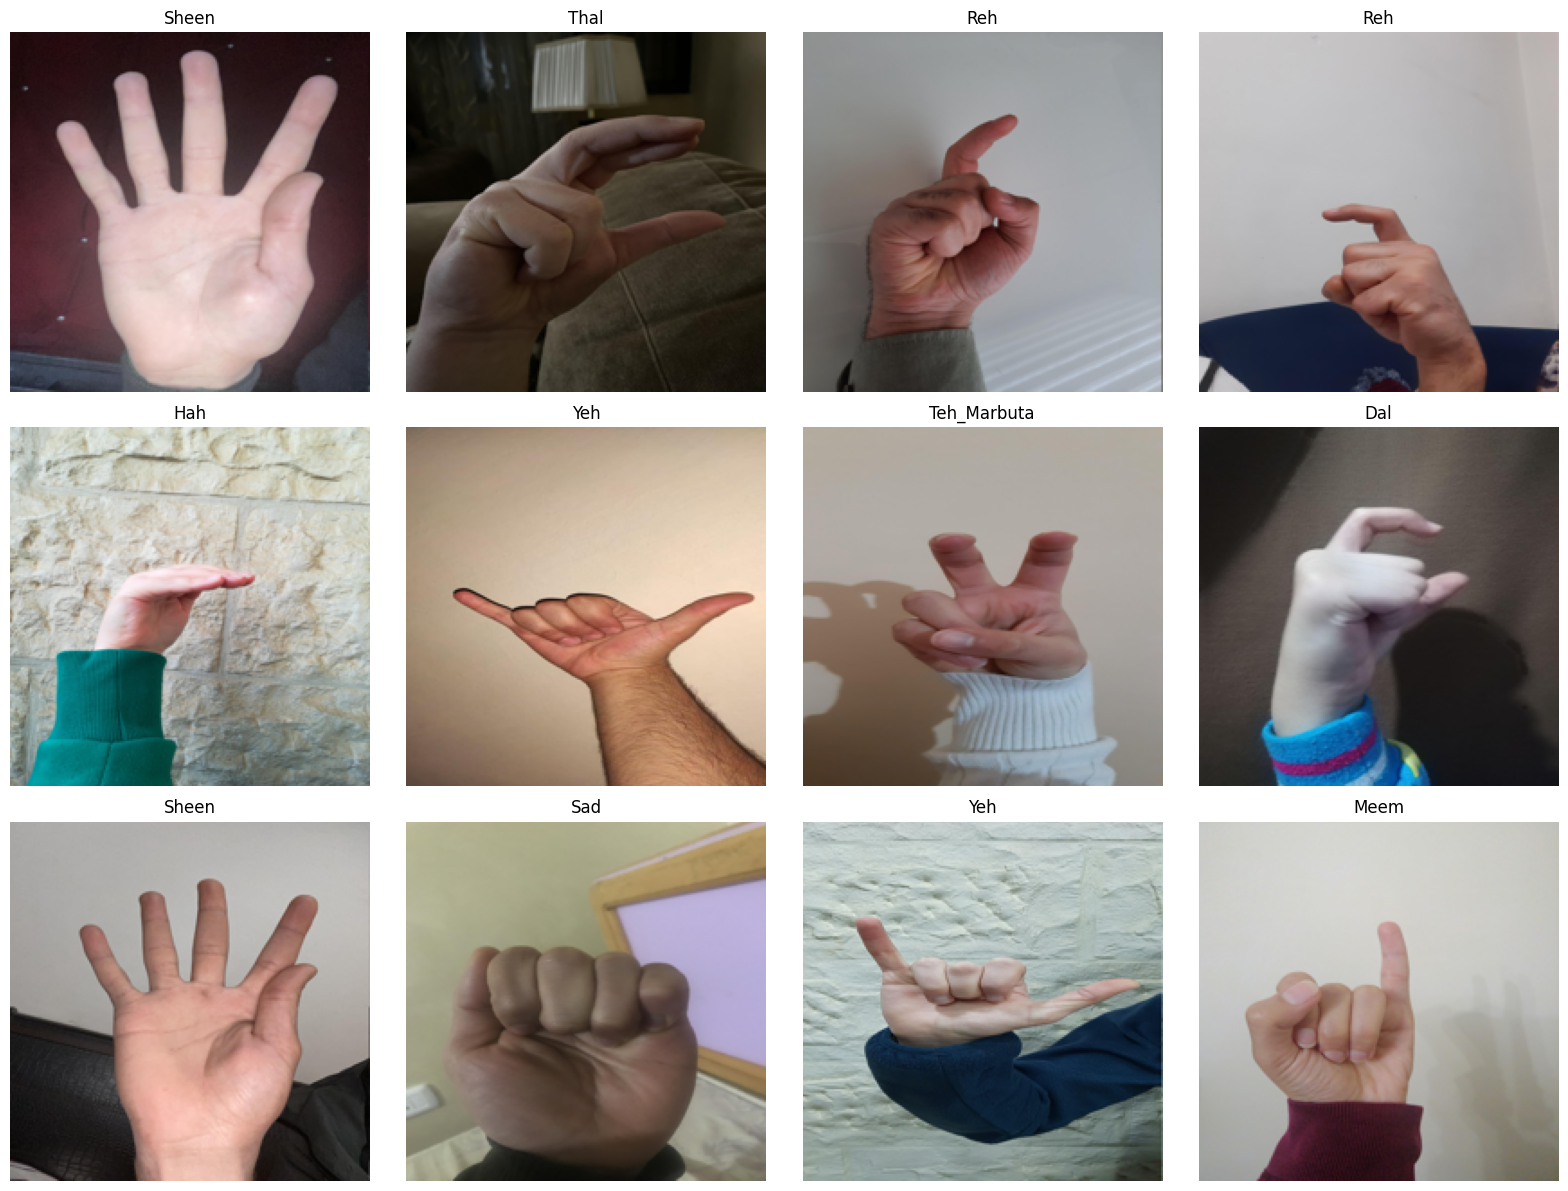

In [6]:
random_indices = random.sample(range(len(X)), 12)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

axes = axes.flatten()

for i, idx in enumerate(random_indices):
    axes[i].imshow(X[idx])
    axes[i].set_title(y[idx])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
np_X = np.array(X)
X_ = np_X.astype('float32')/255.0

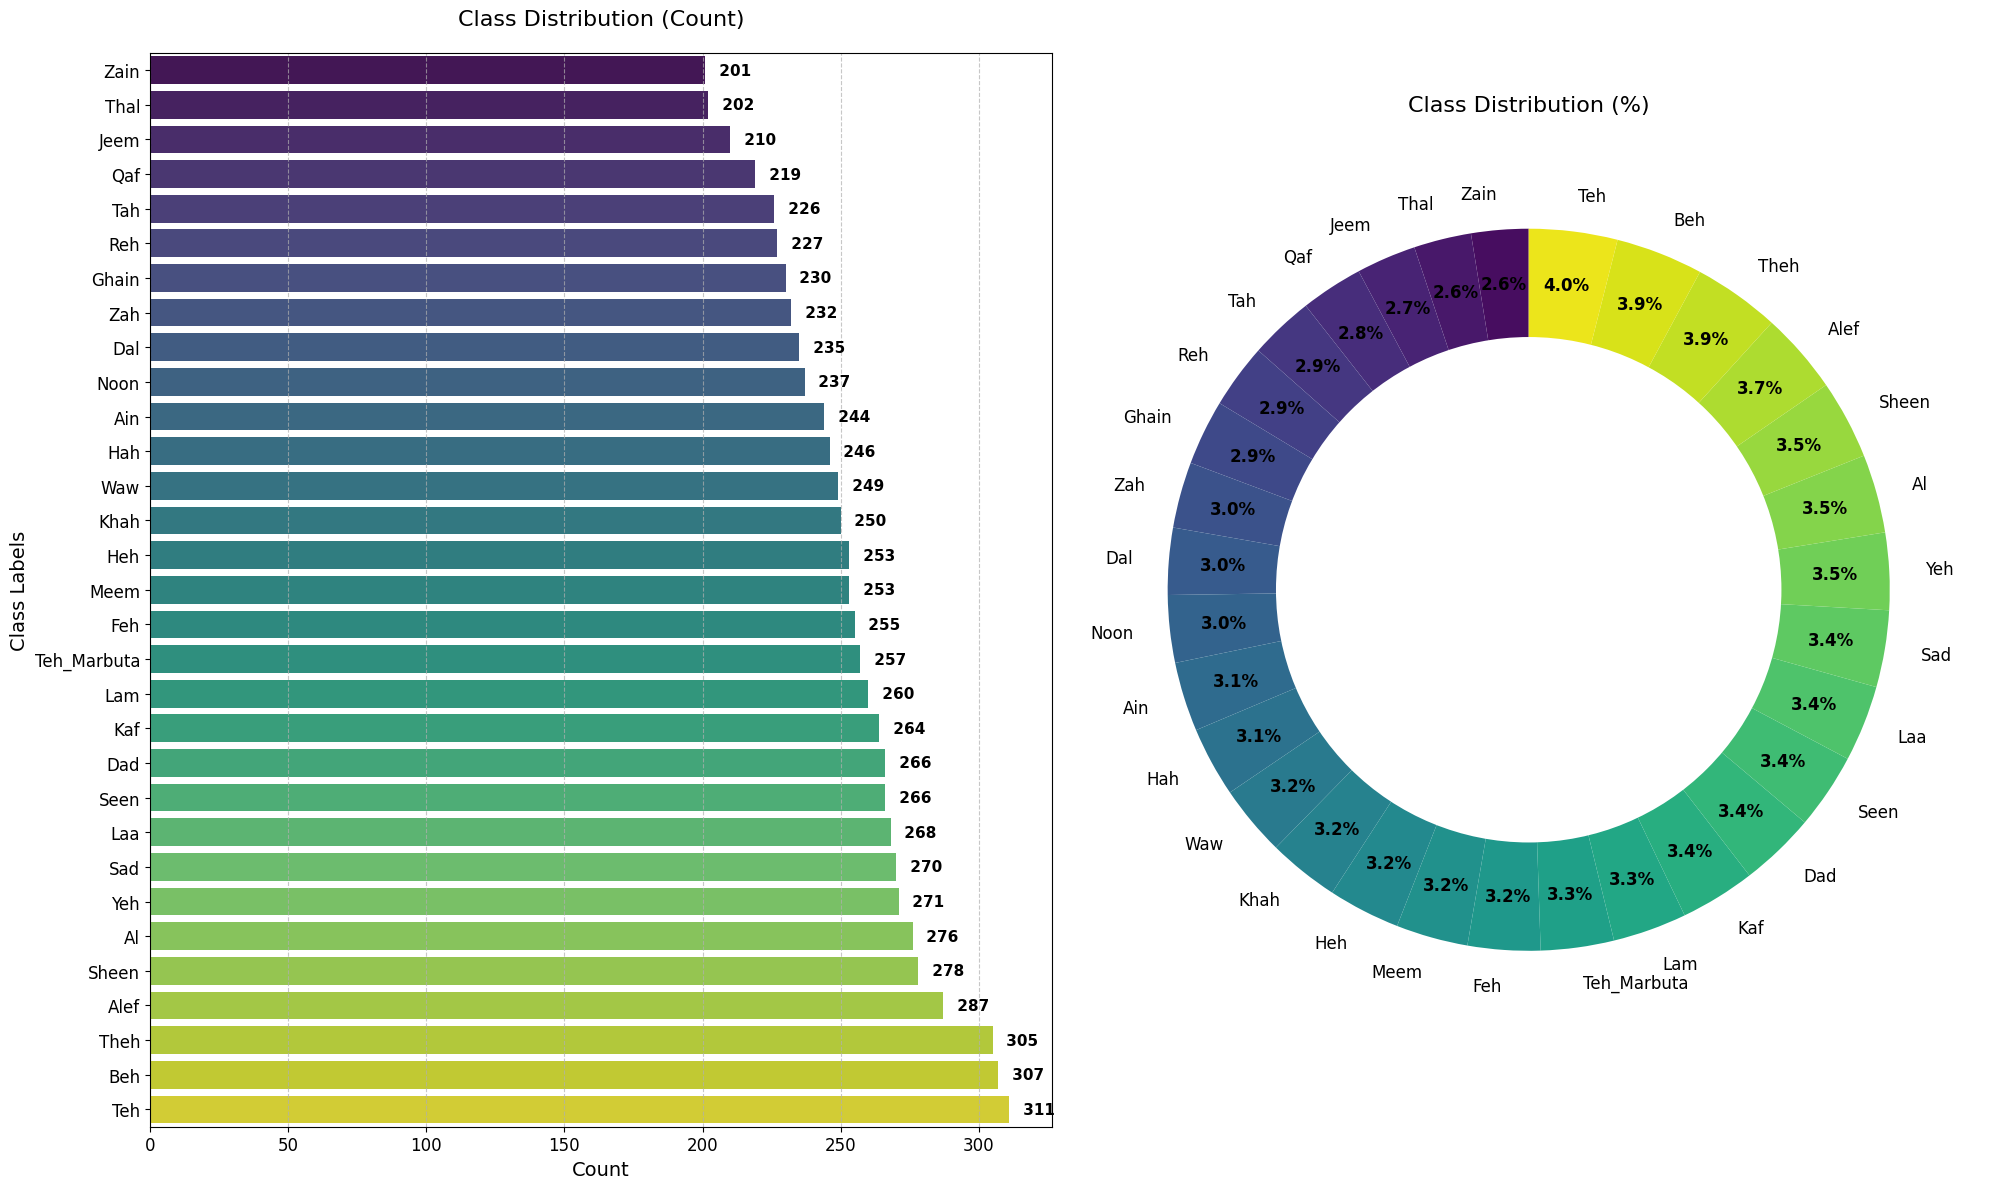

In [8]:
unique_classes, class_counts = np.unique(y, return_counts=True)

sort_idx = np.argsort(class_counts)
sorted_classes = unique_classes[sort_idx]
sorted_counts = class_counts[sort_idx]

plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
ax = sns.barplot(x=sorted_counts, y=sorted_classes, palette='viridis', orient='h')
plt.title('Class Distribution (Count)', fontsize=16, pad=20)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Class Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, count in enumerate(sorted_counts):
    plt.text(count + max(sorted_counts)*0.01, i, f' {count:,}', 
             va='center', fontsize=11, color='black', fontweight='bold')

plt.subplot(1, 2, 2)
wedges, texts, autotexts = plt.pie(sorted_counts, labels=sorted_classes, autopct='%1.1f%%', startangle=90,
                                  colors=sns.color_palette('viridis', n_colors=len(sorted_classes)),
                                  pctdistance=0.85, textprops={'fontsize': 12})

for autotext in autotexts:
    autotext.set_fontweight('bold')

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)
plt.title('Class Distribution (%)', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

In [9]:
le = LabelEncoder()
le.fit(y)
y_ = le.transform(y)

num_classes = len(set(y_))

print(f"number of classes: {num_classes}")

number of classes: 31


In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

In [11]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 5027 samples
Validation set: 1257 samples
Test set: 1571 samples


In [12]:
base_model = VGG19(weights='imagenet',include_top=False , input_shape=(200,200,3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-4:]:
    layer.trainable = True

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1746830395.746610      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 6, 6, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,426,335 (77.92 MB)

 Trainable params: 7,481,375 (28.54 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [13]:
with tf.device('/GPU:0'):
  history = model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      batch_size=32,
      epochs=100
  )

Epoch 1/100


I0000 00:00:1746830407.147890      94 service.cc:148] XLA service 0x7fbdc0002860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746830407.149118      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746830407.588745      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/158 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.0000e+00 - loss: 3.5496

I0000 00:00:1746830415.993090      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


158/158 ━━━━━━━━━━━━━━━━━━━━ 38s 165ms/step - accuracy: 0.0290 - loss: 3.5445 - val_accuracy: 0.0628 - val_loss: 3.3840
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.0703 - loss: 3.3804 - val_accuracy: 0.1519 - val_loss: 3.1293
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.1382 - loss: 3.1032 - val_accuracy: 0.2617 - val_loss: 2.6989
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.1996 - loss: 2.7494 - val_accuracy: 0.4288 - val_loss: 2.2028
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.3072 - loss: 2.3574 - val_accuracy: 0.4773 - val_loss: 1.8417
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.3719 - loss: 2.0650 - val_accuracy: 0.5322 - val_loss: 1.6087
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.4444 - loss: 1.8006 - val_accuracy: 0.5975 - val_loss: 1.4224
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.4919 - loss: 1.609

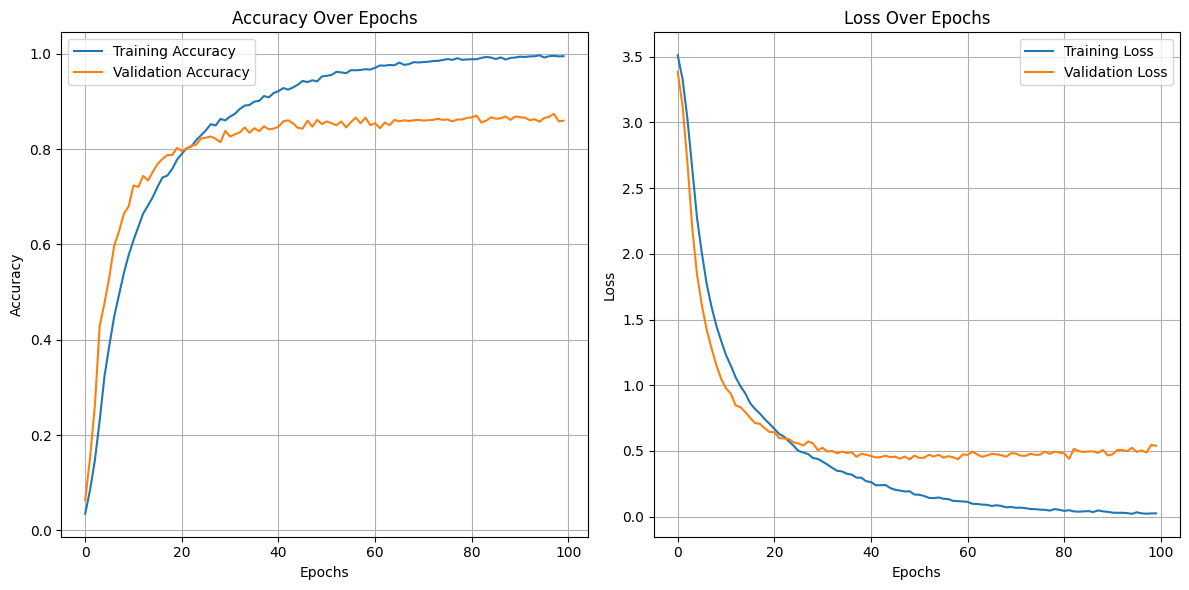

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
with tf.device('/GPU:0'):
  loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8772 - loss: 0.5560
Test Loss: 0.5701
Test Accuracy: 86.57%


In [16]:
with tf.device('/GPU:0'):
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)

y_test_decoded = le.inverse_transform(y_test)
y_pred_classes_decoded = le.inverse_transform(y_pred_classes)

report_dict = classification_report(y_test_decoded, y_pred_classes_decoded, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()

report_df

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step


,precision,recall,f1-score,support
Ain,0.770492,0.959184,0.854545,49.000000
Al,0.925926,0.909091,0.917431,55.000000
Alef,0.963636,0.929825,0.946429,57.000000
Beh,0.896552,0.838710,0.866667,62.000000
Dad,0.852459,0.981132,0.912281,53.000000
Dal,0.693548,0.914894,0.788991,47.000000
Feh,0.732143,0.803922,0.766355,51.000000
Ghain,0.872340,0.891304,0.881720,46.000000
Hah,0.760000,0.775510,0.767677,49.000000
Heh,0.846154,0.862745,0.854369,51.000000


In [17]:
report_df.to_csv('arabic_sign_lang.csv')

<Figure size 800x600 with 0 Axes>

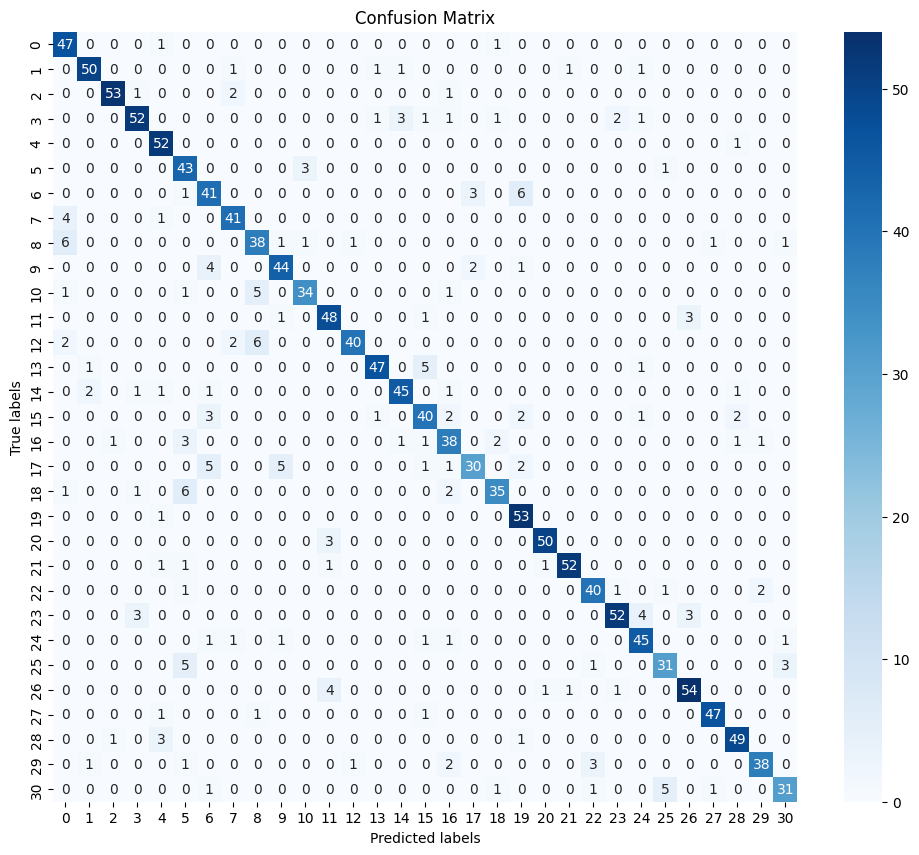

In [18]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [19]:
model.save('arabic_sign_lang.keras')